In [2]:
import sys
print(sys.version)
print(sys.executable)

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
C:\Users\87252\anaconda3\envs\FGSM\python.exe


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets,models

In [4]:
np.random.seed(42)
torch.manual_seed(42)


In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

In [6]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 50000 Validation data: 10000 Test data:  10000


In [7]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [8]:
torch.cuda. is_available()

True

In [14]:
#Defense
# VGG16 for NetF

class NetF(nn.Module):
    def __init__(self):
        super(NetF, self).__init__()
        original_vgg16 = models.vgg16(pretrained=True)
        self.features = original_vgg16.features

        # Adapt the classifier part of VGG16 for MNIST
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # Adjust the first layer to match the feature map size
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 10)  # Output layer for 10 classes
        )

        # Override the forward method
    def forward(self, x):
        # VGG16 expects 3 channel input, so replicate the grayscale MNIST image across 3 channels
        x = x.repeat(1, 3, 1, 1)  # Input is [N, 1, 28, 28] but needs to be [N, 3, 28, 28]
        x = F.interpolate(x, size=(224, 224))  # Resize images from 28x28 to 224x224
        x = self.features(x)  # Apply VGG16 features
        x = torch.flatten(x, 1)
        x = self.classifier(x)  # Classify with the modified classifier
        return x


class NetF1(nn.Module):
    def __init__(self):
        super(NetF1, self).__init__()
        original_vgg16 = models.vgg16(pretrained=True)
        self.features = original_vgg16.features

        # Adapt the classifier part of VGG16 for MNIST
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 2048),  # Adjust the first layer to match the feature map size
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, 10)  # Output layer for 10 classes
        )

        # Override the forward method
    def forward(self, x):
        # VGG16 expects 3 channel input, so replicate the grayscale MNIST image across 3 channels
        x = x.repeat(1, 3, 1, 1)  # Input is [N, 1, 28, 28] but needs to be [N, 3, 28, 28]
        x = F.interpolate(x, size=(224, 224))  # Resize images from 28x28 to 224x224
        x = self.features(x)  # Apply VGG16 features
        x = torch.flatten(x, 1)
        x = self.classifier(x)  # Classify with the modified classifier
        return x

In [15]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  alpha = epsilon/iter
  pert_out = input
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [16]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
        continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)

    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc,adv_examples

In [17]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  #converting target labels to soft labels
  for data in train_loader:
    input, label  = data[0].to(device),data[1].to(device)
    softlabel  = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
        acc, ex = test(model,device,test_loader,eps,1,"fgsm")
        accuracies.append(acc)
        examples.append(ex)
    
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

Fitting the model...
Epoch: 1 Loss: 2.30183308773756 Val_Loss: 2.300948687648773
Epoch: 2 Loss: 2.30146369869709 Val_Loss: 2.30100500061512
Epoch: 3 Loss: 2.301507436451912 Val_Loss: 2.3010779291391374
Epoch: 4 Loss: 2.3014748832273484 Val_Loss: 2.3008465752840044
Epoch: 5 Loss: 2.30139305642128 Val_Loss: 2.300601158285141


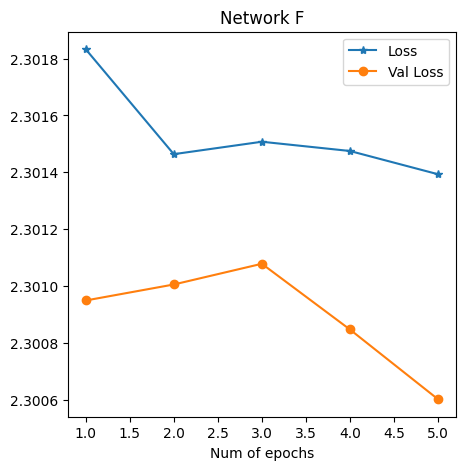

Fitting the model...
Epoch: 1 Loss: 0.12869879868849232 Val_Loss: 0.06266083834132742
Epoch: 2 Loss: 0.057366084012413006 Val_Loss: 0.05235317969038368
Epoch: 3 Loss: 0.05120462076260378 Val_Loss: 0.05298364483862738
Epoch: 4 Loss: 0.04498430399086473 Val_Loss: 0.03977217057749582
Epoch: 5 Loss: 0.05700007922432951 Val_Loss: 0.06454284211653206


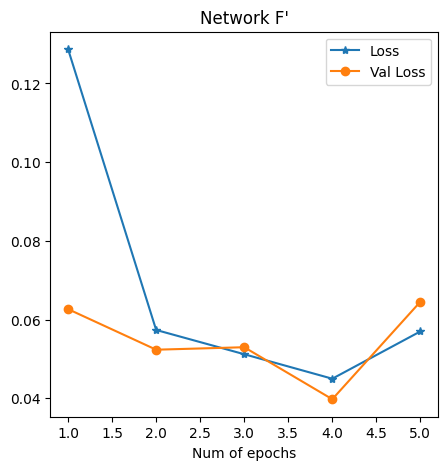

Epsilon: 0	Test Accuracy = 9898 / 10000 = 0.9898
Epsilon: 0.05	Test Accuracy = 9885 / 10000 = 0.9885
Epsilon: 0.1	Test Accuracy = 9885 / 10000 = 0.9885
Epsilon: 0.2	Test Accuracy = 9892 / 10000 = 0.9892
Epsilon: 0.3	Test Accuracy = 9883 / 10000 = 0.9883


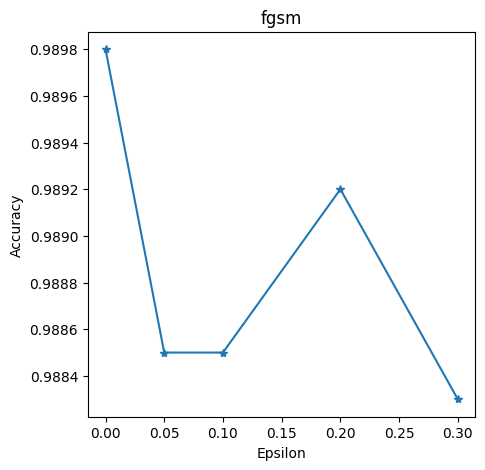

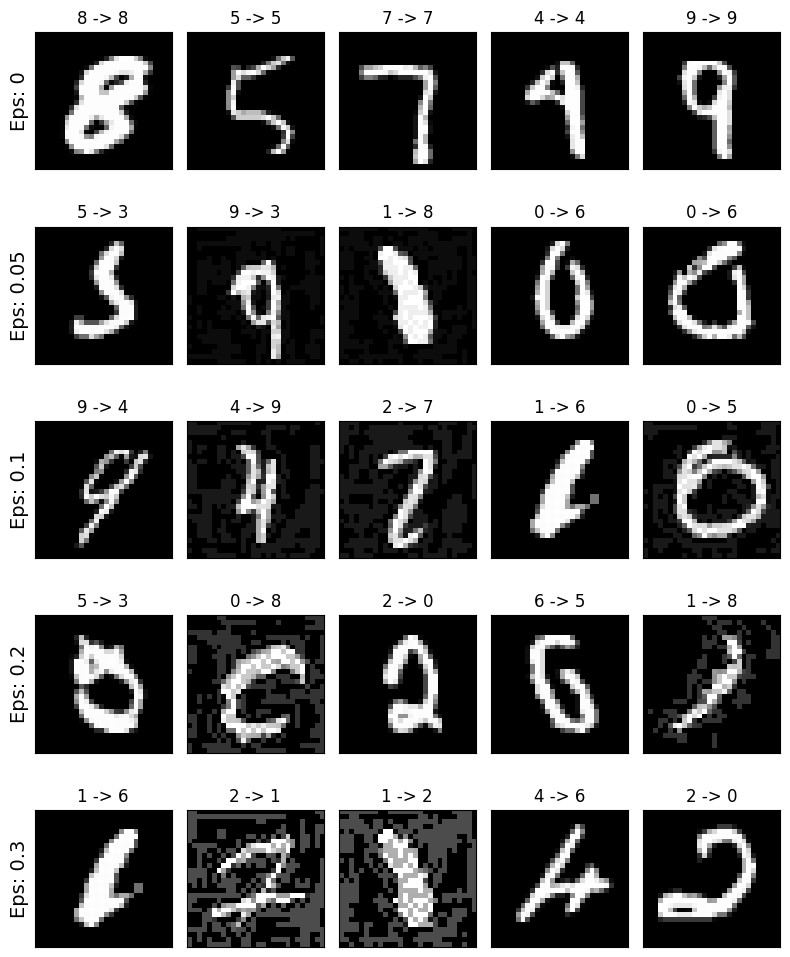

Epsilon: 0	Test Accuracy = 9894 / 10000 = 0.9894
Epsilon: 0.05	Test Accuracy = 9893 / 10000 = 0.9893
Epsilon: 0.1	Test Accuracy = 9886 / 10000 = 0.9886
Epsilon: 0.2	Test Accuracy = 9881 / 10000 = 0.9881
Epsilon: 0.3	Test Accuracy = 9883 / 10000 = 0.9883


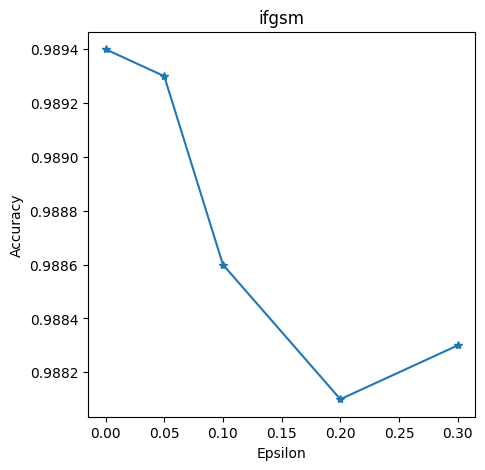

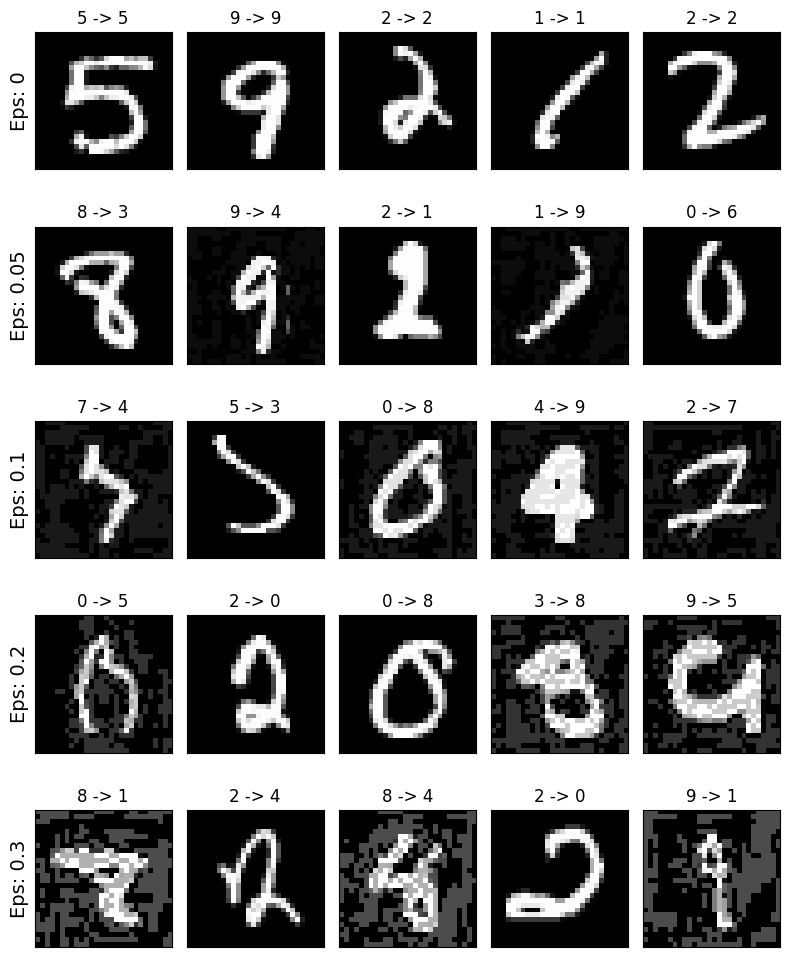

Epsilon: 0	Test Accuracy = 9893 / 10000 = 0.9893
Epsilon: 0.05	Test Accuracy = 9884 / 10000 = 0.9884
Epsilon: 0.1	Test Accuracy = 9886 / 10000 = 0.9886
Epsilon: 0.2	Test Accuracy = 9884 / 10000 = 0.9884
Epsilon: 0.3	Test Accuracy = 9884 / 10000 = 0.9884


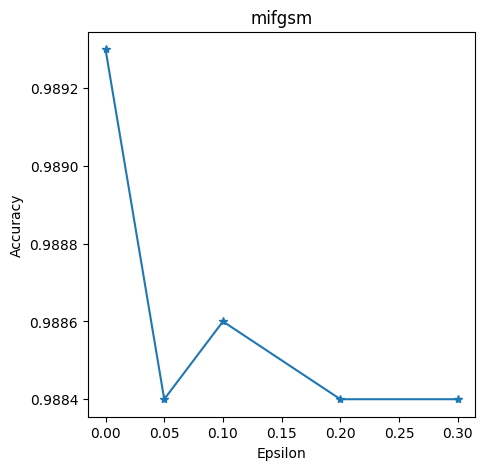

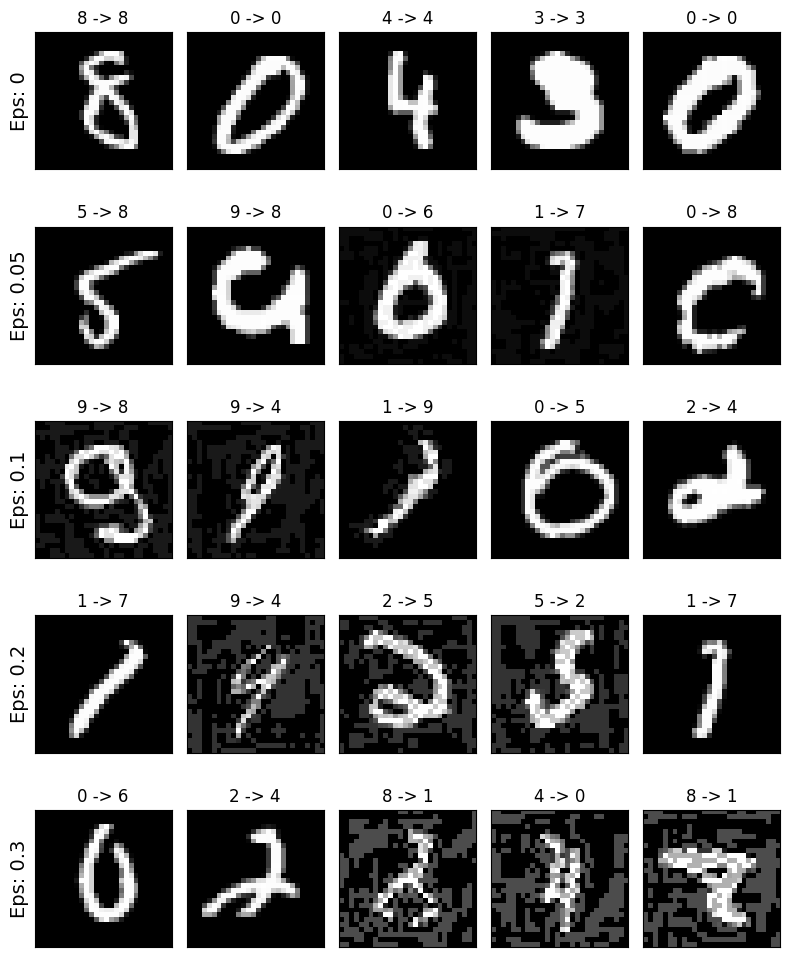

In [18]:
Temp=100
epochs=5
epsilons=[0,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)

In [22]:
torch.cuda. is_available()

True

In [33]:
def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  true_labels = []
  pred_labels = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
        continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)

    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    true_labels.append(target.cpu().numpy())
    pred_labels.append(final_pred.cpu().numpy())
      
    if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc,adv_examples,true_labels, pred_labels

In [34]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  #converting target labels to soft labels
  for data in train_loader:
    input, label  = data[0].to(device),data[1].to(device)
    softlabel  = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
        acc, ex , true_labels, pred_labels= test(model,device,test_loader,eps,1,"fgsm")
        accuracies.append(acc)
        examples.append(ex)
    true_labels_flat = np.concatenate(true_labels)
    pred_labels_flat = np.concatenate(pred_labels)
    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels_flat, pred_labels_flat)
    print(f"Confusion Matrix for Epsilon={eps}:\n", conf_matrix)

    # Compute classification report
    class_report = classification_report(true_labels_flat, pred_labels_flat, digits=4)
    print(f"Classification Report for Epsilon={eps}:\n", class_report)
    
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

C:\Users\87252\anaconda3\envs\FGSM\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\87252\anaconda3\envs\FGSM\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fitting the model...
Epoch: 1 Loss: 0.15137635153831322 Val_Loss: 0.0568602648469531
Epoch: 2 Loss: 0.05983765887479182 Val_Loss: 0.040888022460538104
Epoch: 3 Loss: 0.05182310207488932 Val_Loss: 0.042692311326314084
Epoch: 4 Loss: 0.04715001634234427 Val_Loss: 0.06676090319754846
Epoch: 5 Loss: 0.04370832883154845 Val_Loss: 0.05729052458301308


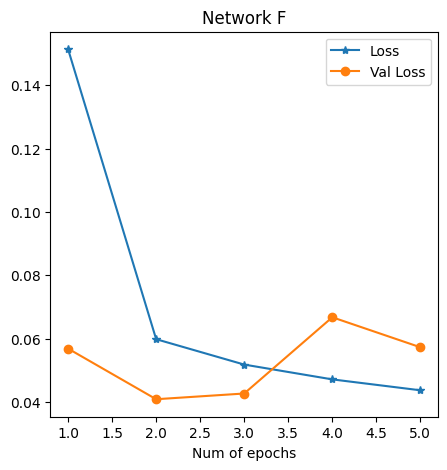

Fitting the model...
Epoch: 1 Loss: 0.1509345297572219 Val_Loss: 0.05975923366960083
Epoch: 2 Loss: 0.06543617812478895 Val_Loss: 0.18257252100651306
Epoch: 3 Loss: 0.05786237219597195 Val_Loss: 0.0532139808684684
Epoch: 4 Loss: 0.049968906943456376 Val_Loss: 0.05511651740433628
Epoch: 5 Loss: 0.0468125862811644 Val_Loss: 0.044036869682678


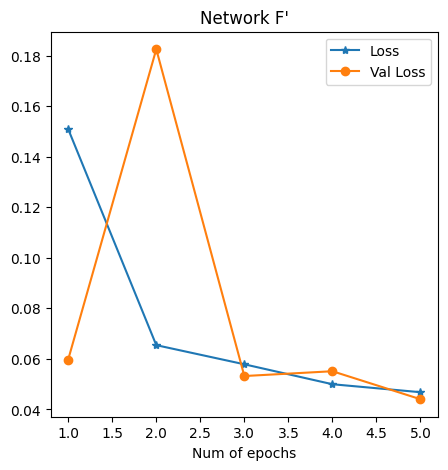

Epsilon: 0.3	Test Accuracy = 9869 / 10000 = 0.9869
Confusion Matrix for Epsilon=0.3:
 [[ 975    0    1    0    0    0    0    0    1    0]
 [   0 1133    0    0    0    0    0    0    0    0]
 [   0    1 1022    0    0    0    0    1    0    0]
 [   0    0    0 1001    0    2    0    0    0    0]
 [   0    0    0    0  960    0    1    2    2    3]
 [   0    1    1    0    0  880    1    0    0    0]
 [   0    1    0    1    1    0  940    0    1    0]
 [   0    0    3    0    0    1    0 1007    0    1]
 [   1    1    1    1    0    1    0    0  957    0]
 [   1    1    1    0    1    1    0    0    2  994]]
Classification Report for Epsilon=0.3:
               precision    recall  f1-score   support

           0     0.9980    0.9980    0.9980       977
           1     0.9956    1.0000    0.9978      1133
           2     0.9932    0.9980    0.9956      1024
           3     0.9980    0.9980    0.9980      1003
           4     0.9979    0.9917    0.9948       968
           5     0

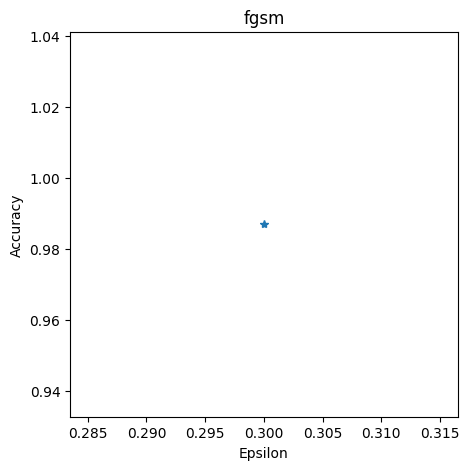

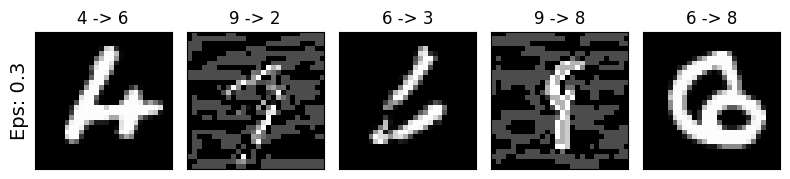

Epsilon: 0.3	Test Accuracy = 9866 / 10000 = 0.9866
Confusion Matrix for Epsilon=0.3:
 [[ 976    0    2    0    0    0    0    0    0    0]
 [   0 1132    0    0    0    0    0    0    0    0]
 [   0    2 1021    0    0    0    0    1    0    0]
 [   0    0    1 1002    0    0    0    1    0    0]
 [   0    0    2    1  961    0    0    0    0    1]
 [   0    1    1    0    0  880    0    0    0    0]
 [   2    3    2    1    0    2  936    0    1    0]
 [   1    2    4    1    0    0    0 1006    0    1]
 [   0    0    2    0    0    0    0    1  957    1]
 [   0    1    2    0    0    2    0    1    1  995]]
Classification Report for Epsilon=0.3:
               precision    recall  f1-score   support

           0     0.9969    0.9980    0.9974       978
           1     0.9921    1.0000    0.9960      1132
           2     0.9846    0.9971    0.9908      1024
           3     0.9970    0.9980    0.9975      1004
           4     1.0000    0.9959    0.9979       965
           5     0

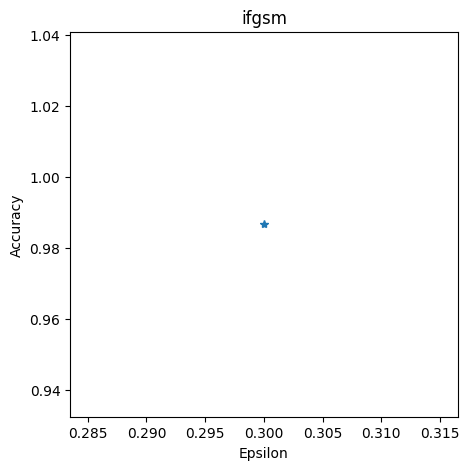

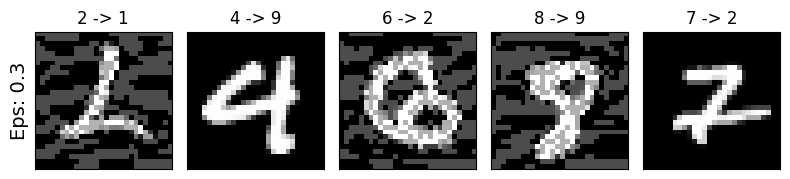

Epsilon: 0.3	Test Accuracy = 9860 / 10000 = 0.986
Confusion Matrix for Epsilon=0.3:
 [[ 974    0    1    0    0    0    0    0    0    0]
 [   0 1132    0    1    0    0    0    0    0    0]
 [   0    1 1023    0    0    0    1    0    0    0]
 [   0    0    0 1001    0    1    0    1    0    0]
 [   1    1    2    0  959    0    0    2    0    1]
 [   0    0    0    0    0  880    1    0    0    0]
 [   0    2    1    0    0    1  939    0    1    0]
 [   0    0    2    1    0    0    0 1005    0    0]
 [   0    1    1    0    0    0    0    0  957    1]
 [   1    2    0    0    1    7    0    0    1  990]]
Classification Report for Epsilon=0.3:
               precision    recall  f1-score   support

           0     0.9980    0.9990    0.9985       975
           1     0.9939    0.9991    0.9965      1133
           2     0.9932    0.9980    0.9956      1025
           3     0.9980    0.9980    0.9980      1003
           4     0.9990    0.9928    0.9958       966
           5     0.

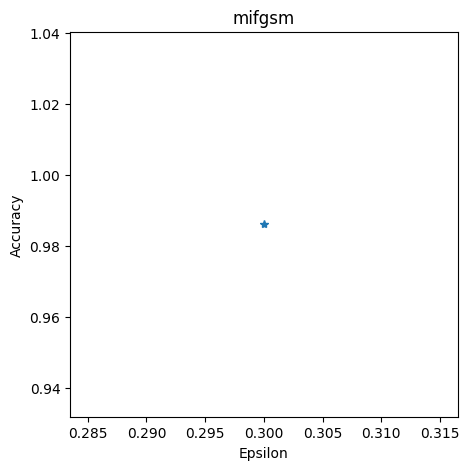

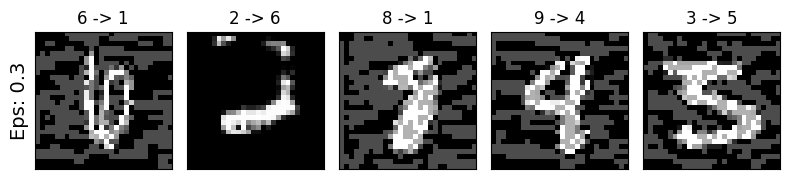

In [35]:
Temp=100
epochs=5
epsilons=[0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)